In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import os
import apt_pkg
apt_pkg.init_system()

In [6]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]

In [16]:
survey=pd.read_csv('./survey.csv', sep=",")

In [18]:
survey.rename(columns={'What could be the most appropriate version of a library to use?':"question",
                      'Which programming languages you used?':'language'}, inplace=True)
survey = survey.query('question != "Has many contributors"')

In [19]:
df_tmp = survey.groupby('question').count()[['Horodateur']].reset_index().sort_values('Horodateur')

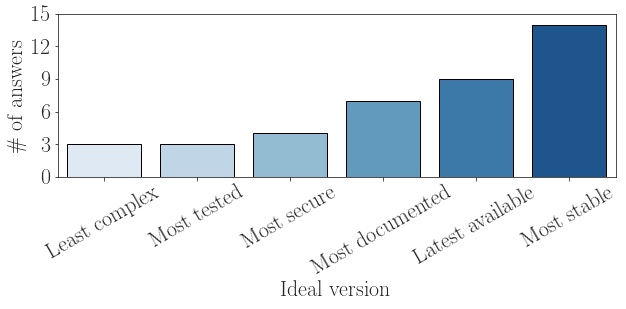

In [20]:
ax = sns.barplot(
    y="Horodateur", x='question', data=df_tmp, 
    palette="Blues", linewidth=1)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_xlabel("Ideal version")
ax.set_ylabel("\# of answers")
ax.figure.set_size_inches(10,3)
plt.xticks(rotation=30)
plt.yticks(np.arange(0, 16, 3.0))

ax.figure.savefig('../../thesis/Figs/towards/ideal_survey.pdf', bbox_inches='tight', facecolor='white')


{'major': '1', 'minor': '1', 'patch': '1', 'pre': '-pre1'}

In [110]:
survey[['Years of experience:','Horodateur']].drop_duplicates()['Years of experience:'].mean()

3.0588235294117645

In [95]:
packages=pd.read_csv('/home/neglectos/Desktop/repositories/ConPan/data/debian/packages.csv', sep=";")

In [96]:
packages = packages[['package','version','release_snapshot','date','source','source_version']]

In [98]:
packages.to_csv('/home/neglectos/Desktop/repositories/ConPan/data/debian/packages.csv', index=False,sep=";")

In [3]:
from urllib.parse import urljoin
NPM_URL = 'http://registry.npmjs.org'
import requests

def fetch_from_url(url):
    """Fetch package information from a URL and return its content.
    :param url: the target url
    :return: the content of the url
    """
    response = requests.get(url)

    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError as error:
        logger.error(error)

    to_json = response.json()
    return to_json
    
def get_versions(package):
        """Get the version of a given package.
        :param package: target package name
        :return: pandas data frame of package versions
        """
        url = urljoin(NPM_URL, package)
        versions = fetch_from_url(url)['time']
        versions.pop('modified')
        versions.pop('created')
        versions = (pd.DataFrame({'version_compare': list(versions.keys()),
                                  'date': list(versions.values()),
                                  'package': package}))
        
        versions['version_compare'] = versions['version_compare'].apply(lambda x: x.split('-')[0])
        versions.drop_duplicates(inplace=True)
        return versions


In [5]:
import pandas as pd
get_versions('spdx-correct')

,version_compare,date,package
0,1.0.0,2015-04-29T21:43:57.752Z,spdx-correct
1,1.0.0,2015-05-03T21:24:40.155Z,spdx-correct
2,1.0.0,2015-05-06T07:49:06.723Z,spdx-correct
3,1.0.0,2015-06-05T18:53:29.241Z,spdx-correct
4,1.0.0,2015-06-05T21:58:47.978Z,spdx-correct
5,1.0.1,2015-08-23T23:57:24.167Z,spdx-correct
6,1.0.2,2015-10-26T16:55:34.193Z,spdx-correct
7,2.0.0,2017-02-14T19:00:53.136Z,spdx-correct
8,2.0.1,2017-06-06T19:28:55.612Z,spdx-correct
9,2.0.2,2017-06-07T22:39:24.699Z,spdx-correct


In [177]:
packages_registry = pd.DataFrame()
packages_registry = pd.concat([packages_registry ,get_versions('glob')])
packages_registry = pd.concat([packages_registry ,get_versions('jasmine')])

In [178]:
RELEASE_MINOR = 'minor'
RELEASE_MAJOR = 'major'
RELEASE_PATCH = 'patch'

def release_type(old_version, new_version):
    """Determine the type of a release by comparing two versions. The
    outcome can be: major, minor or patch.
    :param old_version: The source version of a package
    :param new_version: The target version of a package
    :return: the type of the release
    """
    old_version = str(old_version).split('.')
    new_version = str(new_version).split('.')

    release = RELEASE_PATCH
    if new_version[0] != old_version[0]:
        release = RELEASE_MAJOR
    elif new_version[1] != old_version[1]:
        release = RELEASE_MINOR

In [179]:
packages = ['jasmine','glob']
versions = ['1.1.0','2.2.0']
dff = pd.DataFrame({'package':packages, 'version':versions})
packages_registry = (packages_registry
                     .merge(dff,
                            left_on = 'package',
                            right_on = 'package',
                            how = 'left'
                           )
                    )
len(packages_registry)

136

In [183]:
def convert_version(version):
    """Convert version to a numeric value.
    :param version: the version of a package
    :return: a numeric value of the package version
    """
    major = 0
    minor = 0
    patch = 0

    prog = re.compile("^\d+(\.\d+)*$")
    result = prog.match(version)

    groups = version.split('.')
    if len(groups) >= 1:
        major = int(groups[0]) * 1000000
    if len(groups) >= 2:
        minor = int(groups[1]) * 1000
    if len(groups) >= 3:
        patch = int(groups[2])

    return major + minor + patch

In [184]:
convert_version('2.2.0')

2002000

In [182]:
def convert_version(version):
    """Convert version to a numeric value.
    :param version: the version of a package
    :return: a numeric value of the package version
    """
    major = 0
    minor = 0
    patch = 0

    prog = re.compile("^\d+(\.\d+)*$")
    result = prog.match(version)

    if not result:
        msg = "Impossible to convert version %s" % version
        raise TechLagError(cause=msg)

    groups = version.split('.')
    if len(groups) >= 1:
        major = int(groups[0]) * 1000000
    if len(groups) >= 2:
        minor = int(groups[1]) * 1000
    if len(groups) >= 3:
        patch = int(groups[2])

    return major + minor + patch

def release_type(old_version, new_version):
    """Determine the type of a release by comparing two versions. The
    outcome can be: major, minor or patch.
    :param old_version: The source version of a package
    :param new_version: The target version of a package
    :return: the type of the release
    """
    old_version = str(old_version).split('.')
    new_version = str(new_version).split('.')

    release = RELEASE_PATCH
    if new_version[0] != old_version[0]:
        release = RELEASE_MAJOR
    elif new_version[1] != old_version[1]:
        release = RELEASE_MINOR

    return release

In [188]:
match = re.fullmatch(RE, '1.1.0')
if match is not None:
    v = match.groupdict()
v['major']

'1'

In [1]:
# With 2 parameters
image_official = 'node:stretch'
dir_data = '/home/neglectos/Desktop/repositories/ConPan/data/debian/'
from conpan.conpan import ConPan
cp = ConPan(packages="npm", image=image_official, dir_data=dir_data)
general_info, installed_packages2, tracked_packages2, vulnerabilities2, bugs2 = cp.analyze()

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Connecting to DockerHub... Done
Pulling the Docker image... Done
Extracting installed packages... Done
Tracking installed packages... Done
Identifying vulnerabilities... Done
Identifying other kind of bugs... Done



In [2]:
tracked_packages2

,name,package,version,major_lag,minor_lag,patch_lag,latest,outdate
0,node:stretch,npm,6.7.0,0,2,3,6.9.0,5
1,node:stretch,abbrev,1.1.1,0,0,0,1.1.1,0
2,node:stretch,ansicolors,0.3.2,0,0,0,0.3.2,0
3,node:stretch,ansistyles,0.1.3,0,0,0,0.1.3,0
4,node:stretch,aproba,2.0.0,0,0,0,2.0.0,0
5,node:stretch,archy,1.0.0,0,0,0,1.0.0,0
6,node:stretch,bin-links,1.1.2,0,0,0,1.1.2,0
7,node:stretch,bluebird,3.5.3,0,0,0,3.5.3,0
8,node:stretch,cmd-shim,2.0.2,0,0,0,2.0.2,0
9,node:stretch,gentle-fs,2.0.1,0,0,0,2.0.1,0
